In [1]:
import random
import numpy.random as rnd

from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle
import json

from scipy.integrate import odeint
import scipy.special as sps
import scipy.optimize as spo
from scipy.integrate import odeint
#import interp1d
import scipy.optimize as so
from scipy.interpolate import interp1d

# from jupyter_server import serverapp as app; 
# import ipykernel, requests;

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Helvetica"],
# })
sns.set_theme(context='talk')
sns.set_style("white")
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.labelsize']=25
plt.rcParams['legend.fontsize']= 15
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['figure.titlesize'] = 30

In [2]:
sys.path.append('..')
from src.evo_eq_model_new import fractional_fun_modified
def model_w_params(R0, N, yc, control_fun): 
    def model(X,t):
        S = X[0]
        I = X[1]
        y = I/N
        x= S/N

        R0_eff = R0 * control_fun(y,x,yc,R0)
        dSdt = - R0_eff * S*y
        dIdt = I *  (R0_eff * x - 1)
        return [dSdt,dIdt]
    return model

def t_peak_func(R0,yc,N):
    t_ext = 20*np.log(N)/(R0-1)
    ts_det = np.linspace(0,t_ext,5000)
    x,y = odeint(model_w_params(R0,N, yc, fractional_fun_modified), [N-10, 10], ts_det).T
    tp = ts_det[np.argmax(y)]
    
    return tp

In [3]:
# N_ex = df['N'].unique()[0]
# R0_ex = df['R0'].unique()[0]
# yc_ex = 1e-5

# t_ext = 20*np.log(N_ex)/(R0_ex-1) #+ N_ex*(1-1/R0_ex)/yc_ex
# ts_det = np.linspace(0,t_ext,5000)
# S,I = odeint(model_w_params(R0_ex,N_ex, yc_ex, fractional_fun_modified), [N_ex-10, 10], ts_det).T
# x,y = S/N_ex,I/N_ex
# tp = ts_det[np.argmax(y)]

# fig,ax = plt.subplots(1,1)
# ax.plot(ts_det, y, label='Fraction of infected', color='blue')
# # ax.set_xscale('log')
# # ax.set_xlim(0,200)

In [4]:
from pandarallel import pandarallel 
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [5]:
df = pd.concat((pd.read_feather('2025-05-17new_df_observables_pd_data.feather'),
               pd.read_feather('2025-05-17_0_new_df_observables_pd_data.feather'),
               pd.read_feather('2025-05-18new_df_observables_pd_data.feather'),))

df['delta'] = 1/(df['p_alpha']*df['xi'])
df['muN'] = df['mu']*df['N']

df['t_peak'] = 2*np.log(df['N']*df['yc'])/(df['R0']-1)

In [6]:
df.columns

Index(['R0', 'yc', 'nu', 'mu', 'p_alpha', 'xi', 'mu_bd', 'N', 'dimensionality',
       'seed', 'dbar_over_xi', 'muN_yc_times_dbar_over_xi', 'outcome',
       't_intersection', 'd_intersection', 'n_contenders_for_intersection',
       'elapsed', 't_birth', 'delta', 'muN', 't_peak'],
      dtype='object')

In [7]:
extinct_df = df[df['outcome'] == 'extinct']

extinction_proba_df = df.groupby(['R0', 'yc', 'nu', 'muN', 'delta']).agg({'outcome': lambda x: (x == 'extinct').mean()}).reset_index()



In [8]:
delta_s = df.delta.unique()

In [9]:
zinf = lambda yc,R0: 1 - R0**(-1) + yc/(R0-1)


def m_func_low(yc,R0,delta): ## early mutants
    return yc/R0 * (zinf(yc,R0)/zinf(0,R0))**(-1/delta)

def m_func_high(yc,R0,delta): ## selection driven mutants (late mutants)
    return delta/(1+delta) * zinf(0,R0)**2 * (zinf(yc,R0)/zinf(0,R0))**(2-1/delta)

def m_func_total(yc,R0,delta):
    return m_func_low(yc,R0,delta) + m_func_high(yc,R0,delta)

def E_low(yc,R0,delta):
    return 1/m_func_low(yc,R0,delta) 

def E_high(yc,R0,delta):
    return 1/m_func_high(yc,R0,delta)

def E_total(yc,R0,delta):
    return 1/m_func_total(yc,R0,delta)

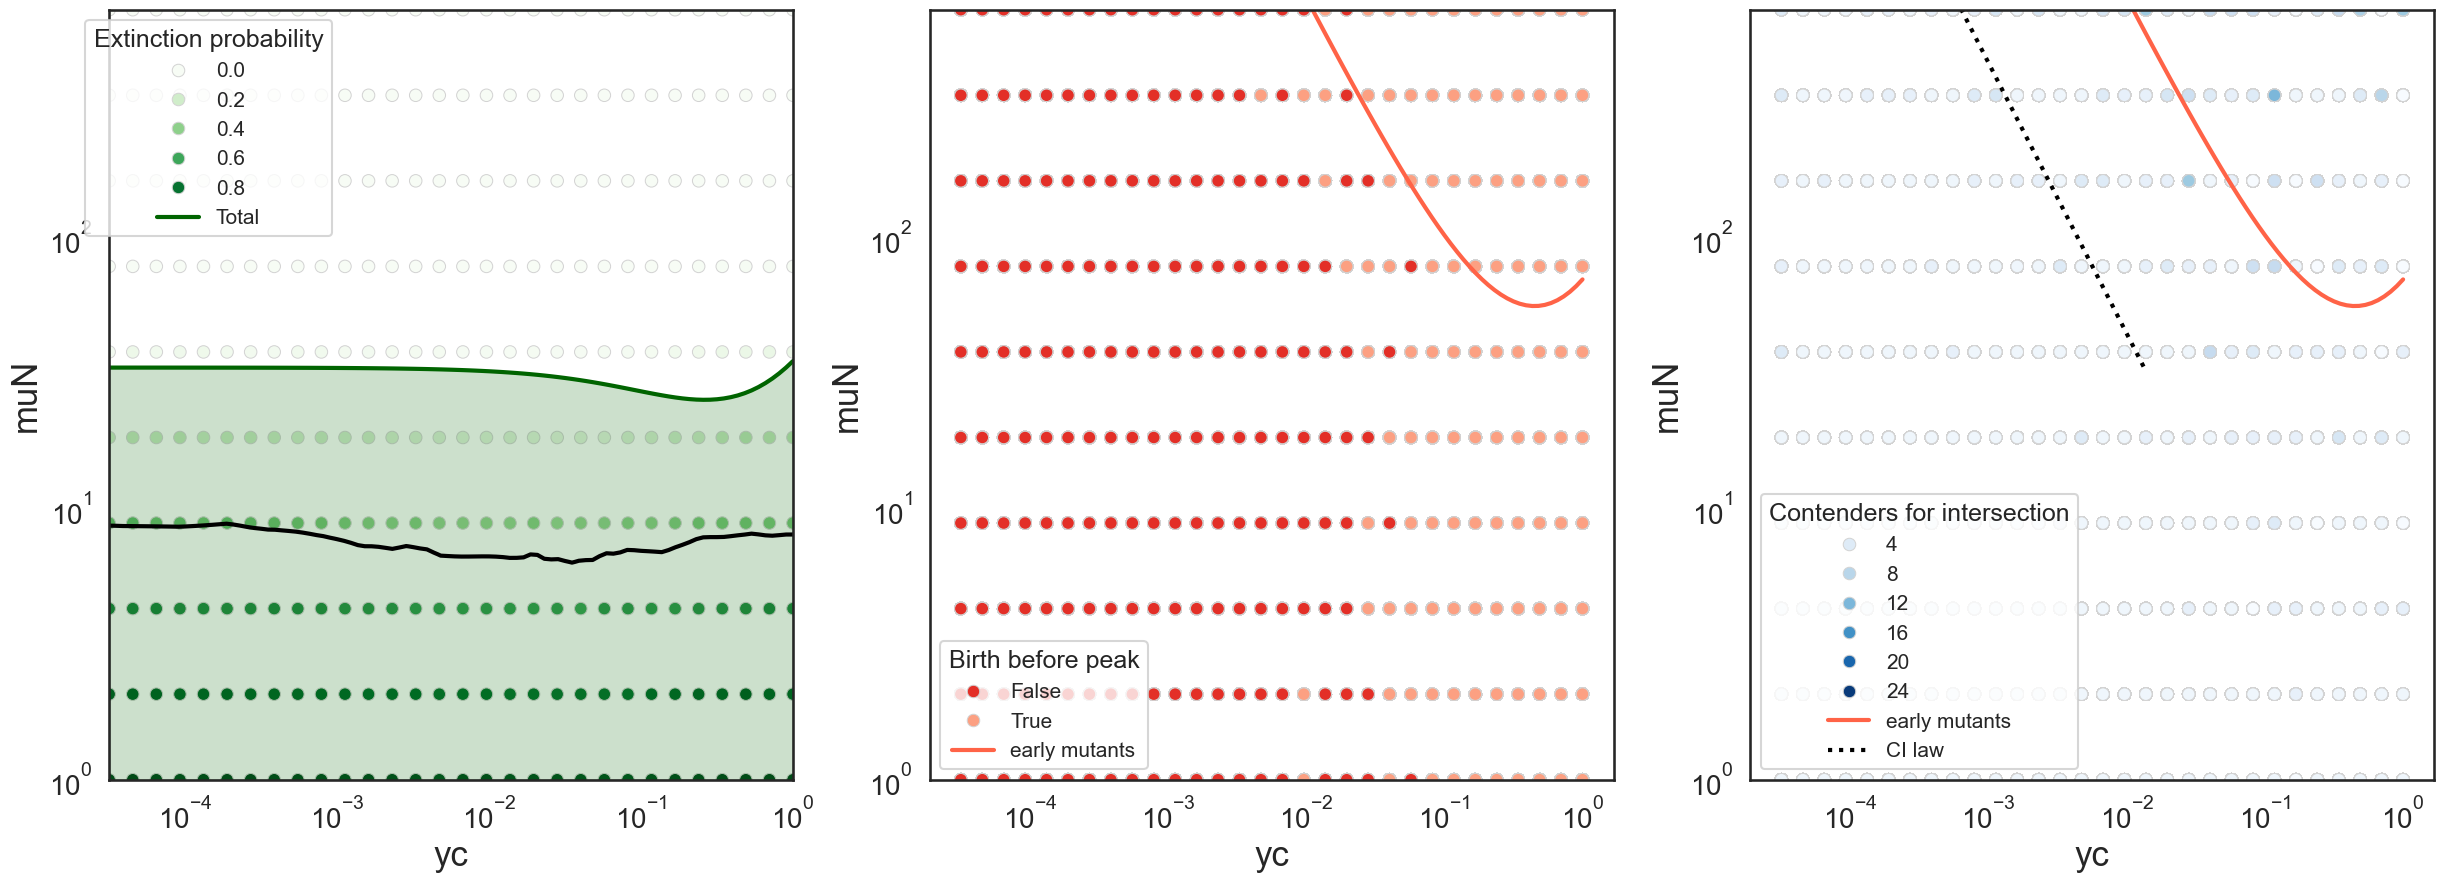

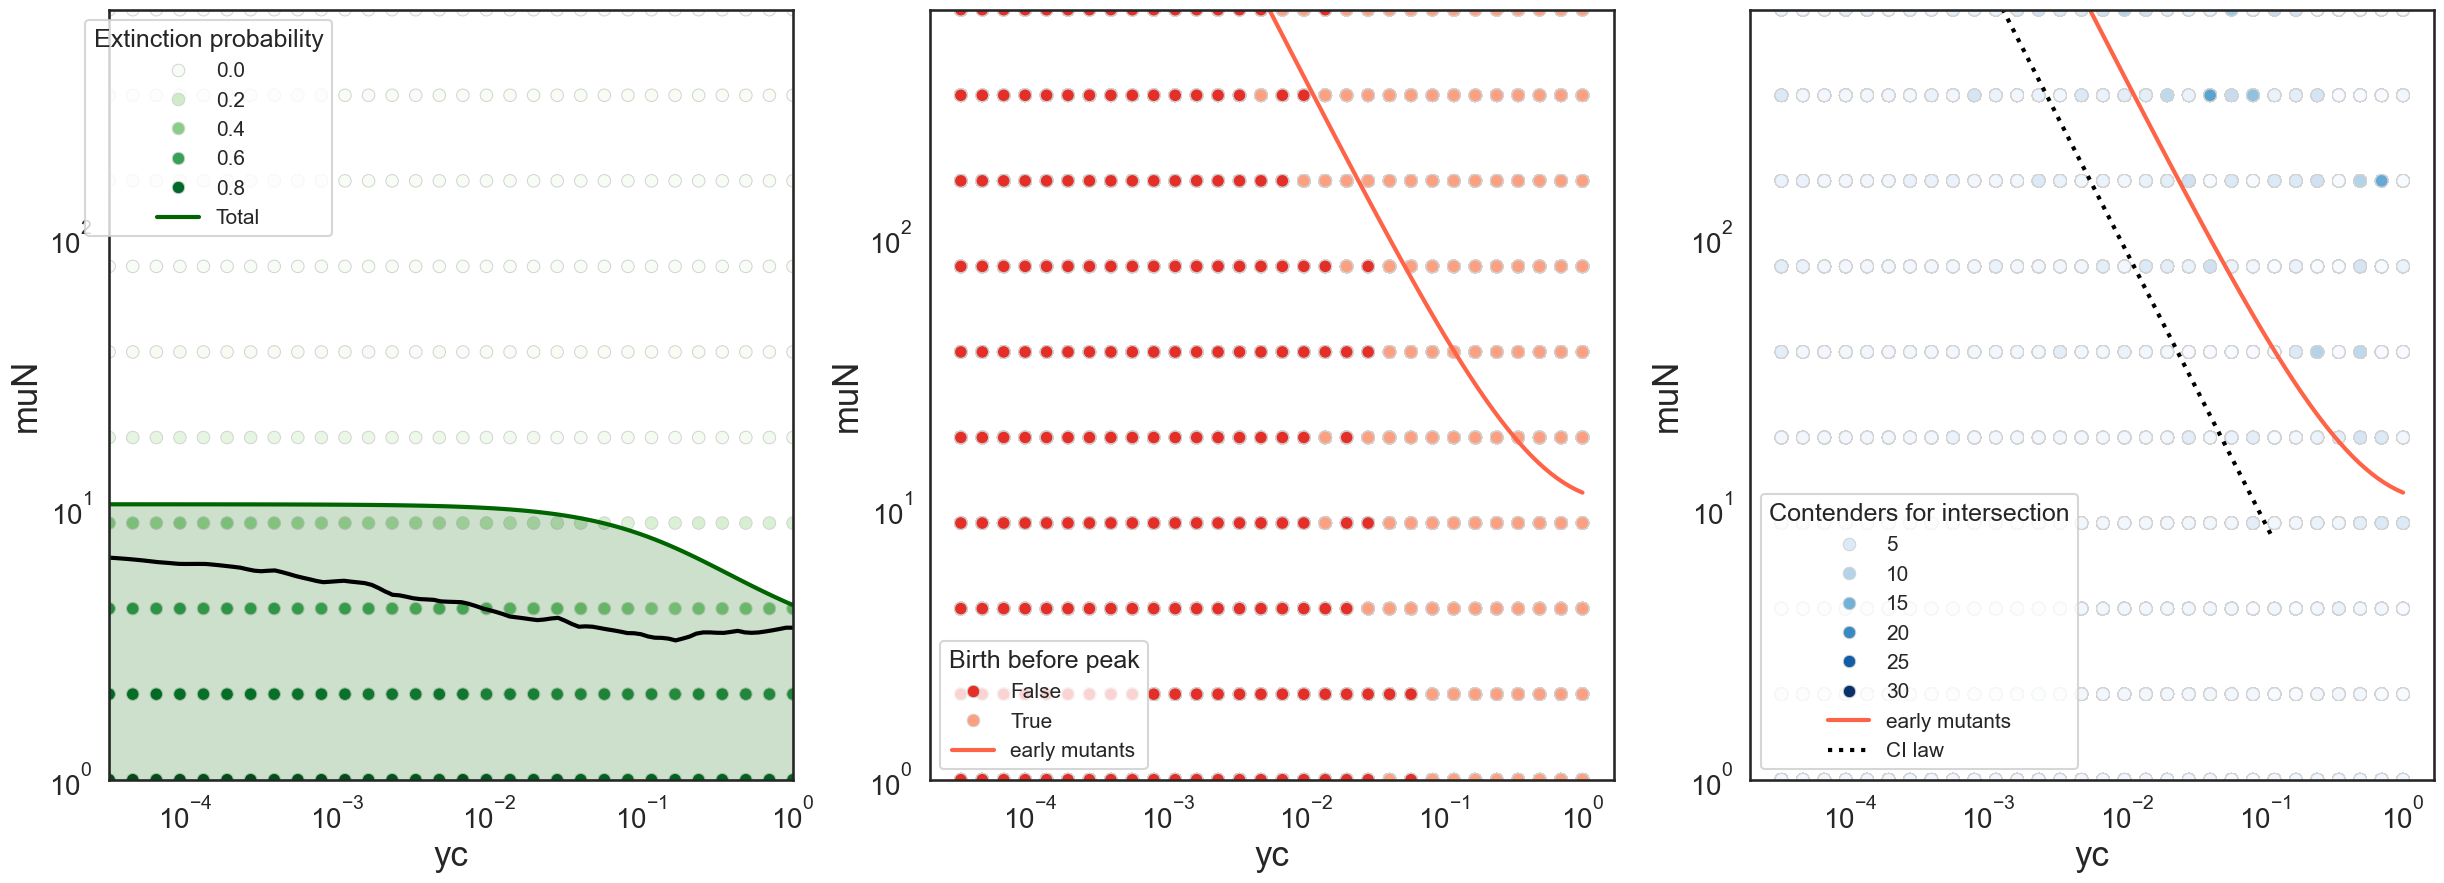

In [10]:
from scipy.interpolate import griddata
delta = delta_s[0]
R0 = df['R0'].unique()[0]

for delta in delta_s:

    ycs = np.logspace(-4.5,0,100)
    UNs_total = E_total(ycs, R0, delta)/delta
    UNs_selection_driven = E_high(ycs, R0, delta)/delta
    UNs_exponential = E_low(ycs, R0, delta)/delta


    x0_df = extinction_proba_df['yc']
    y0_df = extinction_proba_df['muN']
    query0_df = extinction_proba_df['delta'] == delta
    hue0_df = extinction_proba_df['outcome']
    fig,ax= plt.subplots(1,3,figsize=(30, 10))  
    sns.scatterplot(
        x = x0_df[query0_df],
        y = y0_df[query0_df],
        hue = hue0_df[query0_df],
        palette = 'Greens',
        ax = ax[0],
        edgecolor = 'lightgrey',
        # alpha = 0.5,
    )
    ax[0].plot(ycs, UNs_total, label='Total',color='darkgreen')
    ax[0].fill_between(ycs,1, UNs_total, alpha=0.2, color='darkgreen')

    x = x0_df[query0_df]
    y = y0_df[query0_df]
    z = extinction_proba_df['outcome'][query0_df]

    # define grid
    xi = np.logspace(np.log10(x.min()), np.log10(x.max()), 100)
    yi = np.logspace(np.log10(y.min()), np.log10(y.max()), 100)
    X, Y = np.meshgrid(xi, yi)

    # interpolate
    Z = griddata((x, y), z, (X, Y), method='linear')
    cf = ax[0].contour(X, Y, Z, levels=[0.5, 1], colors=['black'], alpha=1)

    ax[0].set_yscale('log')    
    ax[0].set_xscale('log')
    ax[0].legend(title='Extinction probability', bbox_to_anchor=(-.05, 1), loc='upper left')

    x1_df = df['yc']
    y1_df = df['muN']
    hue1_df = df['t_birth'] < df['t_peak']
    query1_df = (~np.isinf(df['t_intersection'])) & (df['delta'] == delta)

    sns.scatterplot(
        x = x1_df[query1_df],
        y = y1_df[query1_df],
        hue = hue1_df[query1_df],
        palette = 'Reds_r',
        ax = ax[1],
        edgecolor = 'lightgrey',
        # alpha = 0.5,
    )
    ax[1].plot(ycs, UNs_exponential, label='early mutants',color= 'tomato',)
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    ax[1].legend(title='Birth before peak', loc='lower left')

    x2_df = df['yc']
    y2_df = df['muN']
    hue2_df = df['n_contenders_for_intersection']
    query2_df = (~np.isinf(df['t_intersection'])) & (df['delta'] == delta)

    sns.scatterplot(
        x = x2_df[query2_df],
        y = y2_df[query2_df],
        hue = hue2_df[query2_df],
        palette = 'Blues',
        ax = ax[2],
        edgecolor = 'lightgrey',
        # alpha = 0.5,
    )
    ax[2].plot(ycs, UNs_exponential, label='early mutants',color= 'tomato',)
    UNs_ci = 4/(3* ycs*np.log((4*ycs*np.sqrt(delta/ycs))/(np.sqrt(3)*1e-4)))
    UNs_ci = delta * 4/(3* ycs)

    ax[2].plot(ycs[UNs_ci > UNs_total], UNs_ci[UNs_ci > UNs_total], label='CI law', color='black', ls=':')


    ax[2].set_yscale('log')
    ax[2].set_xscale('log')
    ax[2].legend(title='Contenders for intersection', loc='lower left')

    for a in ax:
        a.set_ylim(ax[0].get_ylim())

In [11]:
muNs = np.sort(df['muN'].unique())
ycs = np.sort(df['yc'].unique())
print(muNs)


[  1.           2.07072299   4.28789369   8.87904002  18.38603226
  38.07237963  78.83735163 163.2503162  338.04618225 700.        ]


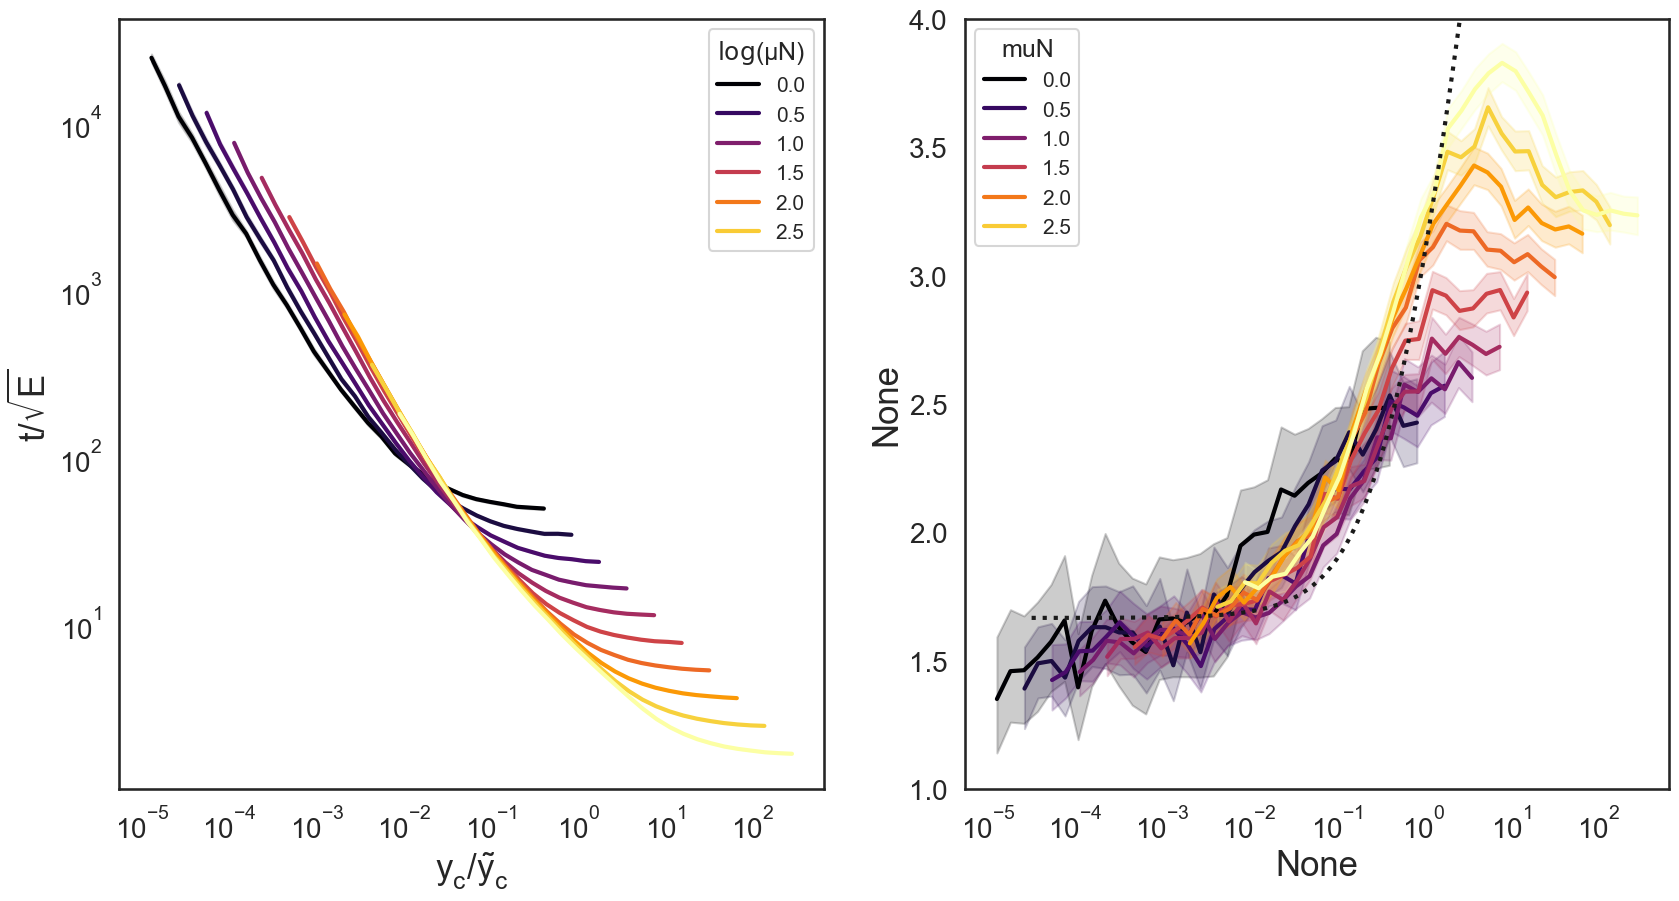

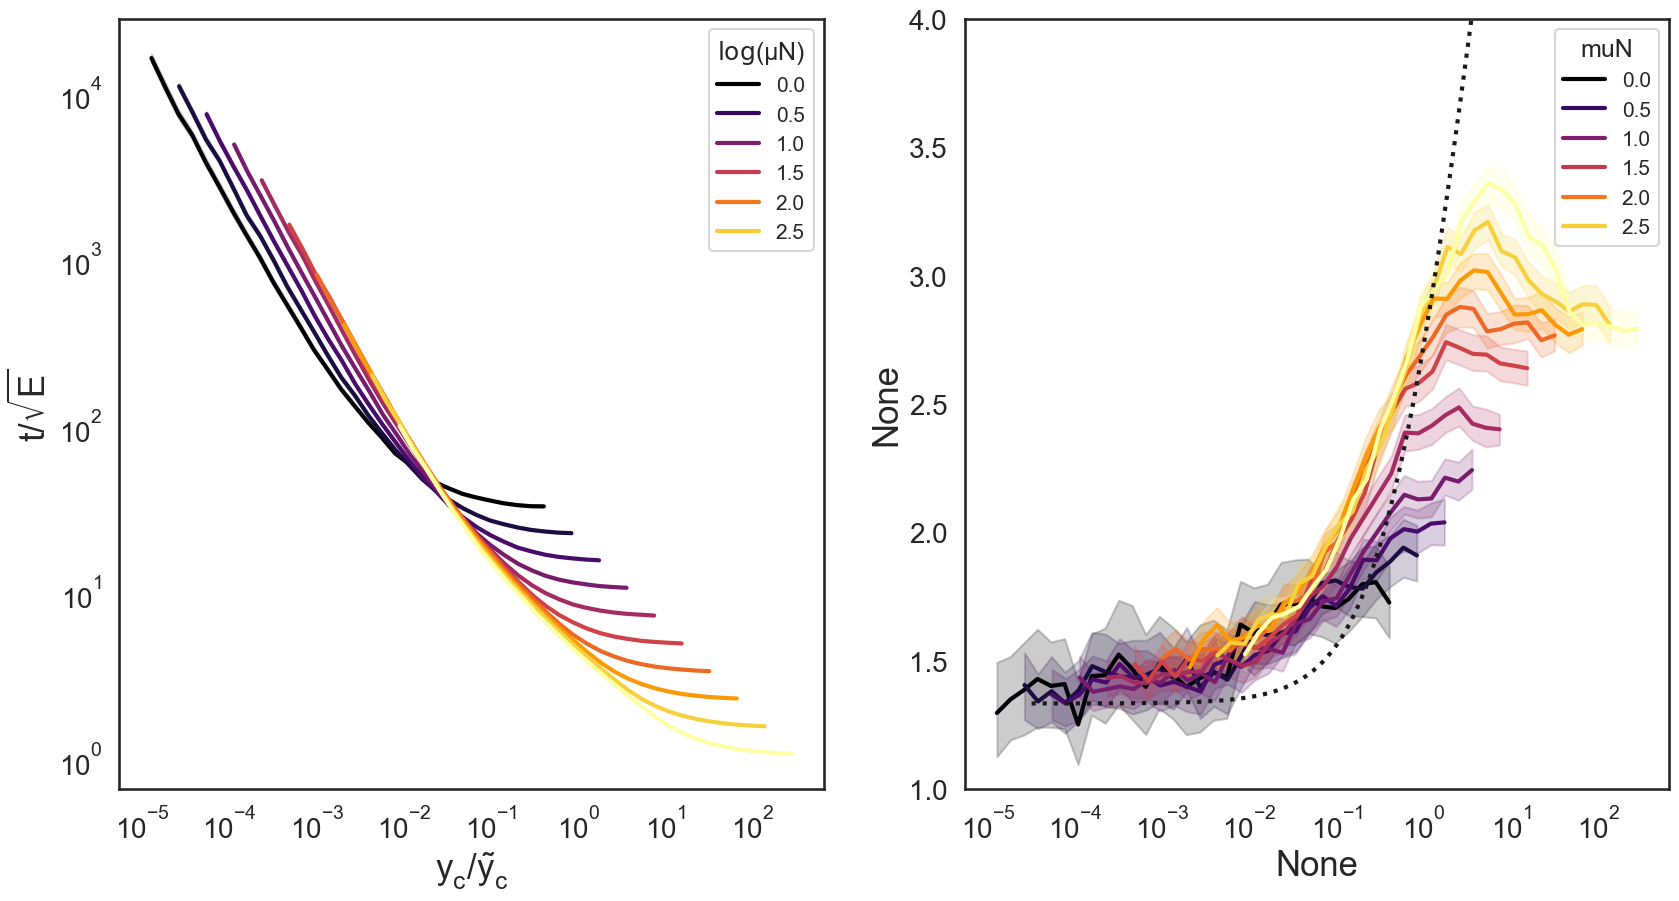

In [12]:
xi= np.unique(df['xi'])
for delta in delta_s:
    fig,ax = plt.subplots(1, 2, figsize=(20, 10))
    df_yc_tilde = df['R0']/df['muN']
    df_E = df['muN']*df['delta']

    x0_df= df['yc']/df_yc_tilde
    y0_df= (df['t_intersection'])/np.sqrt(df_E)
    hue0_df= np.round(np.log10(df['muN']),2)
    query0_df = (df['delta'] == delta) & (df['outcome'] != 'extinct')
    x0_df.label = r'$y_c/\tilde{y}_c$'   

    sns.lineplot(
        x = x0_df[query0_df],
        y = y0_df[query0_df],
        hue = hue0_df[query0_df],
        palette = 'inferno',
        ax = ax[0],)
    ax[0].set_yscale('log')
    ax[0].set_xscale('log')
    ax[0].set_xlabel(r'$y_c/\tilde{y}_c$')
    ax[0].set_ylabel(r'$t/\sqrt{E}$')
    ax[0].legend(title=r'$\log(\mu N$)', loc='upper right')
    
    x1_df= df['yc']/df_yc_tilde
    y1_df= df['d_intersection']*df['p_alpha']
    hue1_df= np.round(np.log10(df['muN']),2)
    query1_df = (df['delta'] == delta) & (df['outcome'] != 'extinct')
    sns.lineplot(
        x = x1_df[query1_df],
        y = y1_df[query1_df],
        hue = hue1_df[query1_df],
        palette = 'inferno',
        ax = ax[1],)
    # ax[1].set_yscale('log')
    ax[1].set_xscale('log')


    ycs_over_ytilde = np.logspace(-4.5,1,100)
    ms = 1 +1/2 * R0* ycs_over_ytilde # ytilde = R0/muN
    dm_over_dbar = (2*(1-delta/2)+  np.log(ms*(1+np.log(ms))))

    ax[1].plot(ycs_over_ytilde, dm_over_dbar, color='k', ls=':', label=r'$\frac{d}{\bar{d}}$')
    ax[1].set_ylim(1,4)

    # ax[2].plot(ycs_over_ytilde/R0, ms, label='m', color='black', ls=':')
    
    # x2_df= df['yc']
    # y2_df= df['n_contenders_for_intersection']
    # hue2_df= np.round(np.log10(df['muN']),2)
    # query2_df = (df['delta'] == delta) & (df['outcome'] != 'extinct')
    # sns.lineplot(
    #     x = x2_df[query2_df],
    #     y = y2_df[query2_df],
    #     hue = hue2_df[query2_df],
    #     palette = 'inferno',
    #     ax = ax[2],)
    # ax[2].set_xscale('log')

In [13]:
df['E'] = df['muN']*df['delta']/(df['delta']+1)

Text(0, 0.5, '$\\frac{d}{\\bar{d}}$')

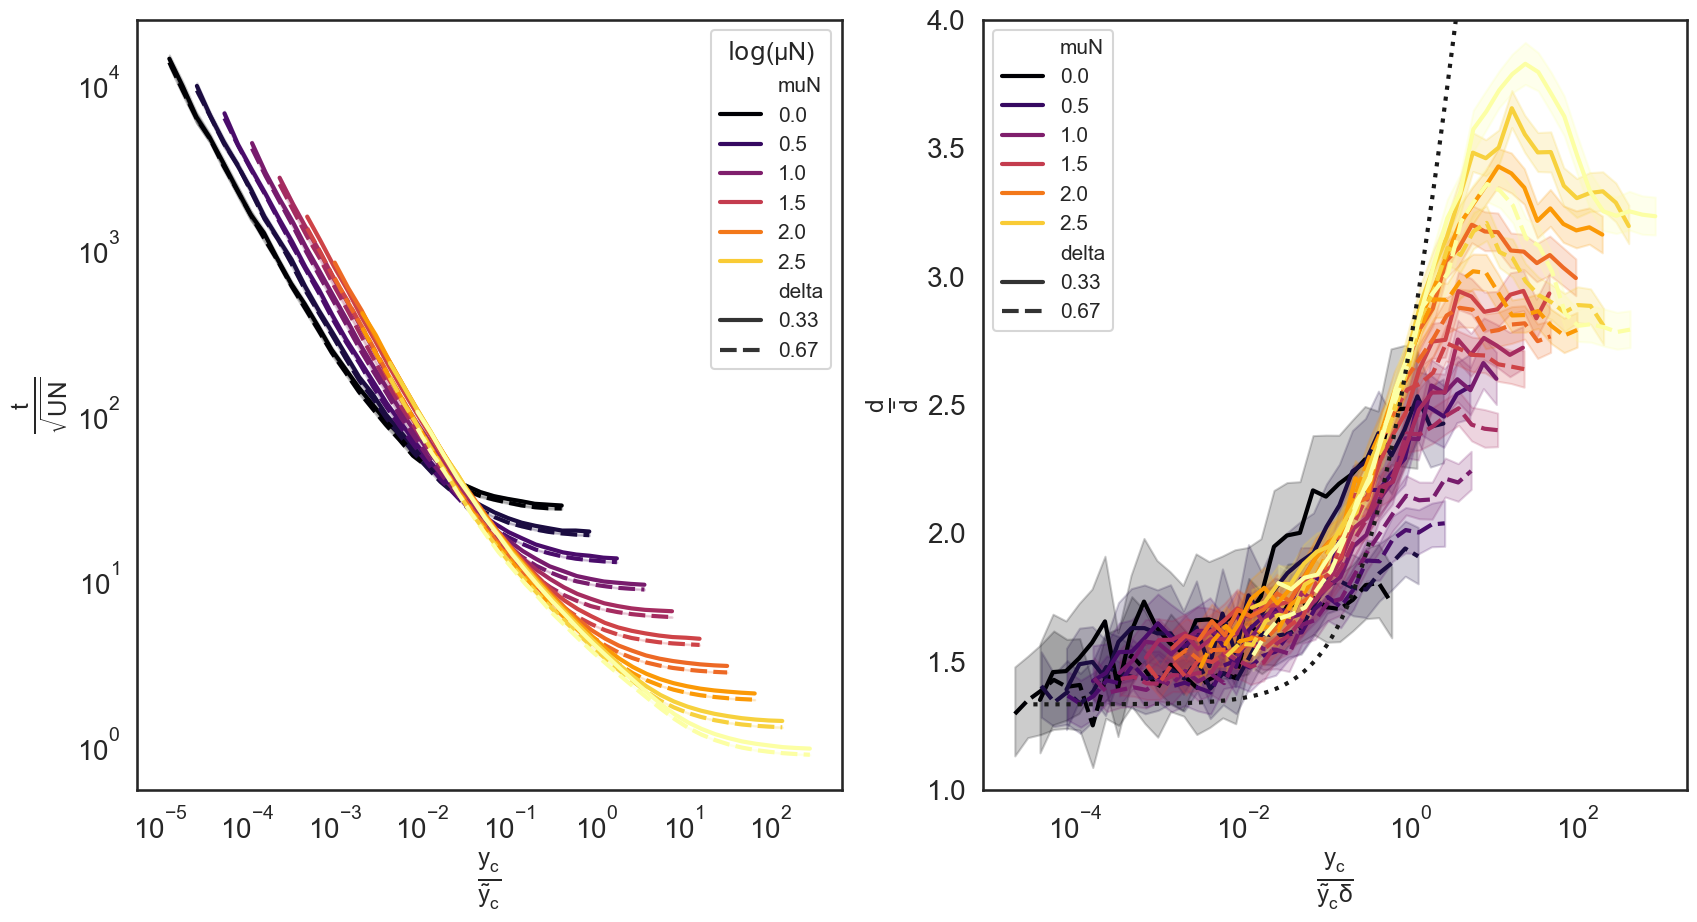

In [14]:
fig,ax = plt.subplots(1, 2, figsize=(20, 10))
df_yc_tilde = df['R0']/(df['muN'] )#* df['delta']
df_E = df['muN']*df['delta']

x0_df= df['yc']/(df_yc_tilde)
y0_df= (df['t_intersection'])/np.sqrt(df['muN'])
hue0_df= np.round(np.log10(df['muN']),2)
query0_df =  (df['outcome'] != 'extinct')
style_df = np.round(df['delta'],2)
x0_df.label = r'$y_c/\tilde{y}_c$'   

sns.lineplot(
    x = x0_df[query0_df],
    y = y0_df[query0_df],
    hue = hue0_df[query0_df],
    style = style_df[query0_df],
    palette = 'inferno',
    ax = ax[0],)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel(r'$y_c/\tilde{y}_c$')
ax[0].set_ylabel(r'$t/\sqrt{E}$')
ax[0].legend(title=r'$\log(\mu N$)', loc='upper right')

df_yc_star = df['R0']/((df['R0']-1)**2 * df['delta'])

x1_df= df['yc']/(df_yc_tilde*df['delta'])
y1_df= df['d_intersection']*df['p_alpha']
hue1_df= np.round(np.log10(df['muN']),2)
query1_df =  (df['outcome'] != 'extinct')
style_df = np.round(df['delta'],2)

sns.lineplot(
    x = x1_df[query1_df],
    y = y1_df[query1_df],
    hue = hue1_df[query1_df],
    style = style_df[query1_df],
    palette = 'inferno',
    ax = ax[1],)
# ax[1].set_yscale('log')
ax[1].set_xscale('log')

for delta in delta_s:    
    ycs_over_ytilde = np.logspace(-4.5,1,100)
    ms = 1 +1/2 * R0* ycs_over_ytilde # ytilde = R0/muN
    dm_over_dbar = (2*(1-delta/2)+  np.log(ms*(1+np.log(ms))))

ax[1].plot(ycs_over_ytilde, dm_over_dbar, color='k', ls=':', label=r'$\frac{d}{\bar{d}}$')
ax[1].set_ylim(1,4)

ax[0].set_xlabel(r'$\frac{y_c}{\tilde{y}_c}$')
ax[0].set_ylabel(r'$\frac{t}{\sqrt{UN}}$')

ax[1].set_xlabel(r'$\frac{y_c}{\tilde{y}_c \delta} $')
ax[1].set_ylabel(r'$\frac{d}{\bar{d}}$')    



Text(0, 0.5, '$\\frac{d}{\\bar{d}}$')

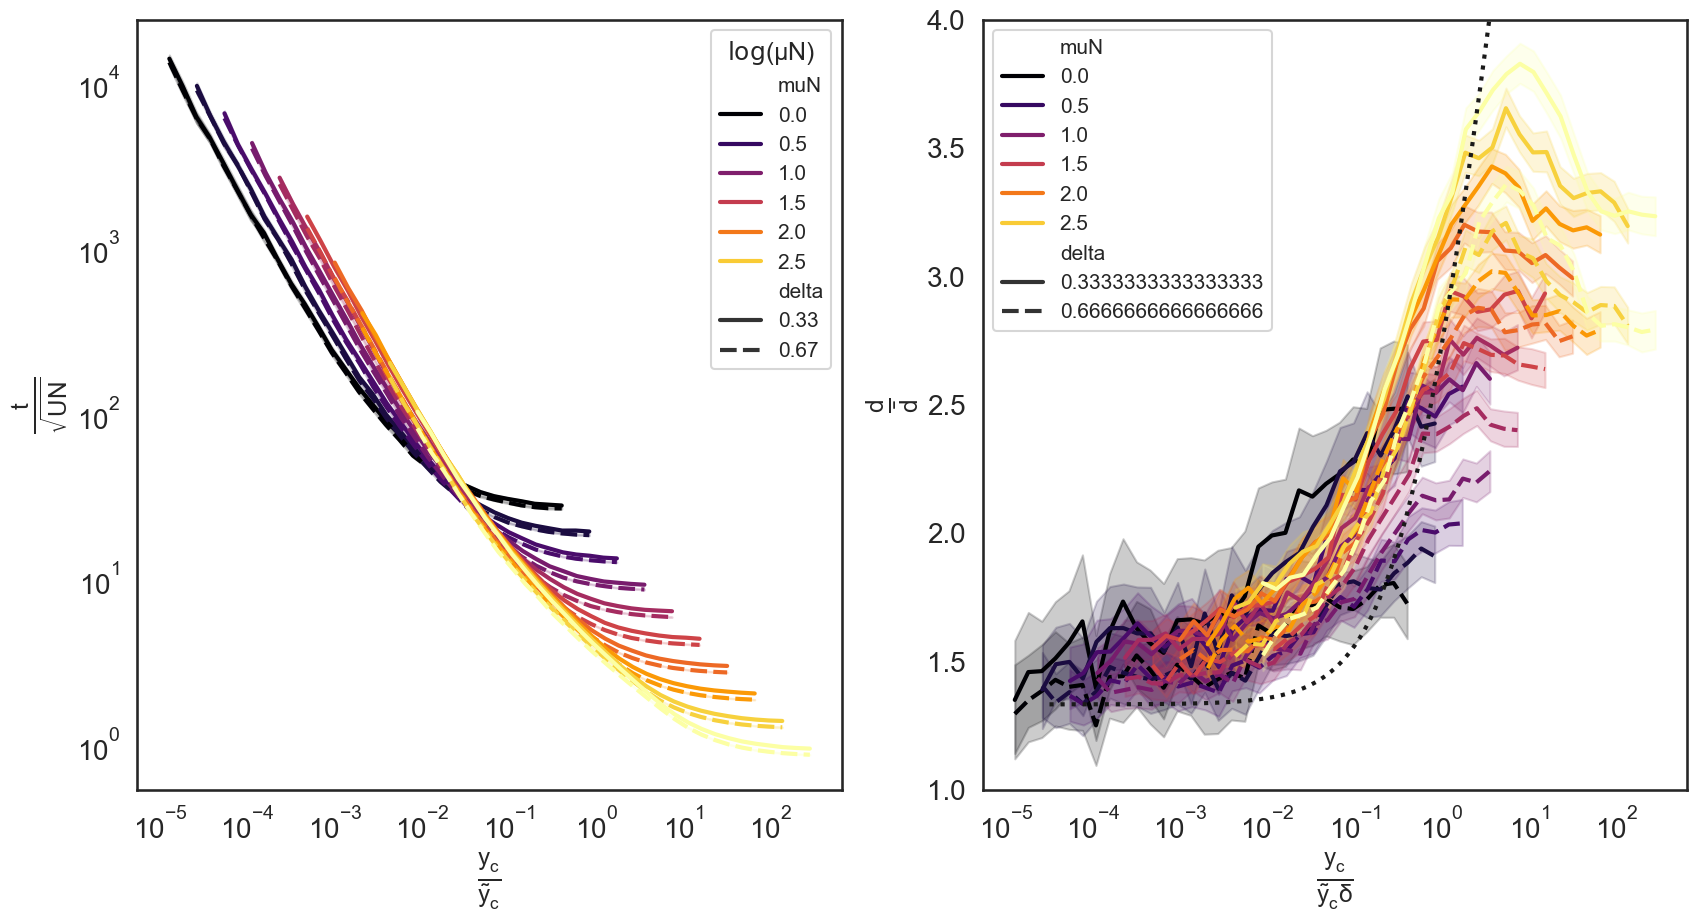

In [15]:
fig,ax = plt.subplots(1, 2, figsize=(20, 10))
df_yc_tilde = df['R0']/(df['muN'] )#* df['delta']
df_E = df['muN']*df['delta']

x0_df= df['yc']/(df_yc_tilde)
y0_df= (df['t_intersection'])/np.sqrt(df['muN'])
hue0_df= np.round(np.log10(df['muN']),2)
query0_df =  (df['outcome'] != 'extinct')
style_df = np.round(df['delta'],2)
x0_df.label = r'$y_c/\tilde{y}_c$'   

sns.lineplot(
    x = x0_df[query0_df],
    y = y0_df[query0_df],
    hue = hue0_df[query0_df],
    style = style_df[query0_df],
    palette = 'inferno',
    ax = ax[0],)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel(r'$y_c/\tilde{y}_c$')
ax[0].set_ylabel(r'$t/\sqrt{E}$')
ax[0].legend(title=r'$\log(\mu N$)', loc='upper right')

df_yc_star = df['R0']/((df['R0']-1)**2 * df['delta'])

x1_df= df['yc']/(df_yc_tilde)
y1_df= df['d_intersection']*(df['p_alpha'])
hue1_df= np.round(np.log10(df['muN']),2)
query1_df =  (df['outcome'] != 'extinct')
style_df = df['delta']
sns.lineplot(
    x = x1_df[query1_df],
    y = y1_df[query1_df],
    hue = hue1_df[query1_df],
    style = style_df[query1_df],
    palette = 'inferno',
    ax = ax[1],)
# ax[1].set_yscale('log')
ax[1].set_xscale('log')

ycs_over_ytilde = np.logspace(-4.5,1,100)
ms = 1 +1/2 * R0* ycs_over_ytilde # ytilde = R0/muN
dm_over_dbar = (2*(1-delta/2)+  np.log(ms*(1+np.log(ms))))

ax[1].plot(ycs_over_ytilde, dm_over_dbar, color='k', ls=':', label=r'$\frac{d}{\bar{d}}$')
ax[1].set_ylim(1,4)

ax[0].set_xlabel(r'$\frac{y_c}{\tilde{y}_c}$')
ax[0].set_ylabel(r'$\frac{t}{\sqrt{UN}}$')

ax[1].set_xlabel(r'$\frac{y_c}{\tilde{y}_c \delta} $')
ax[1].set_ylabel(r'$\frac{d}{\bar{d}}$')    

/var/folders/37/rlslqlv10p75n6c9kp34ss140000gn/T/ipykernel_98913/2264503503.py:20: RuntimeWarning: divide by zero encountered in log
  ax.plot(ms, np.log(ms*(1+np.log(ms))), color='black', ls='--')
/var/folders/37/rlslqlv10p75n6c9kp34ss140000gn/T/ipykernel_98913/2264503503.py:20: RuntimeWarning: invalid value encountered in multiply
  ax.plot(ms, np.log(ms*(1+np.log(ms))), color='black', ls='--')
/var/folders/37/rlslqlv10p75n6c9kp34ss140000gn/T/ipykernel_98913/2264503503.py:20: RuntimeWarning: invalid value encountered in log
  ax.plot(ms, np.log(ms*(1+np.log(ms))), color='black', ls='--')


Text(0, 0.5, '$d_{intersection}/\\langle d\\rangle - (2-\\delta)$')

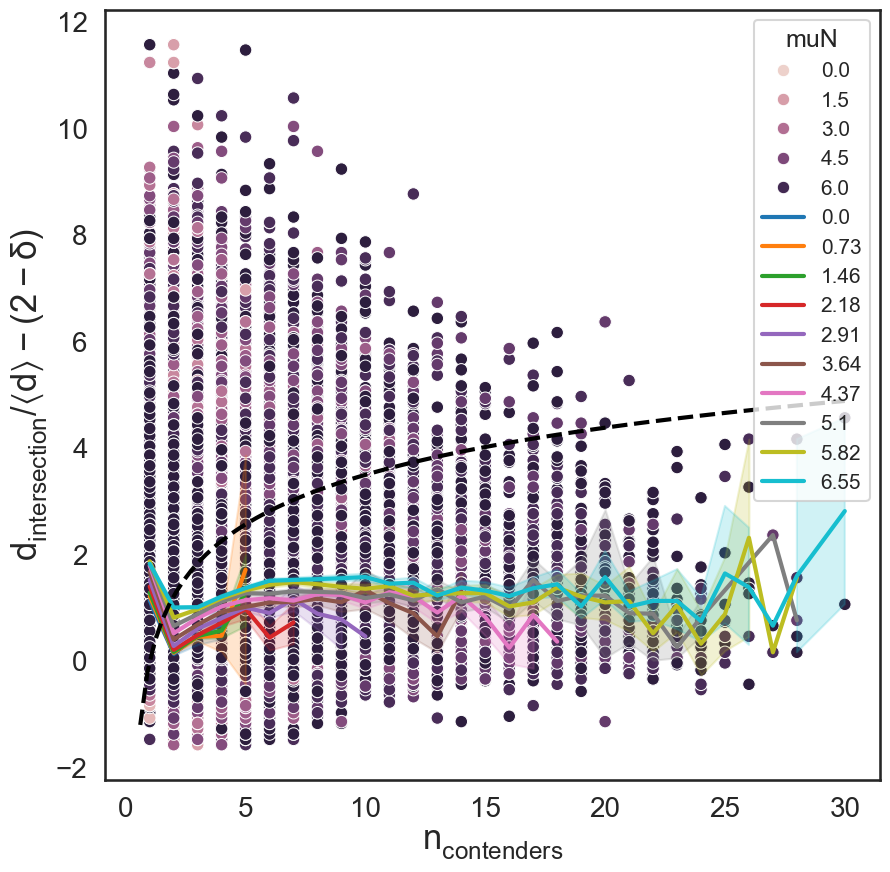

In [16]:
x_df = df['n_contenders_for_intersection']
y_df = df['d_intersection']*df['p_alpha'] - (2- df['delta'])
query_df = df['outcome'] != 'extinct'
hue_df = np.round(np.log(df['muN']),2)
fig,ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(
    x = x_df[query_df],
    y = y_df[query_df],
    hue = hue_df[query_df],
    ax = ax)

sns.lineplot(
    x = x_df[query_df],
    y = y_df[query_df],
    hue = hue_df[query_df],
    palette = 'tab10',
    ax = ax)

ms = np.linspace(0,30,100)
ax.plot(ms, np.log(ms*(1+np.log(ms))), color='black', ls='--')
ax.set_xlabel(r'$n_{contenders}$')
ax.set_ylabel(r'$d_{intersection}/\langle d\rangle - (2-\delta)$')

In [17]:
hue2_df

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
299995    3.0
299996    2.0
299997    2.0
299998    2.0
299999    1.0
Name: n_contenders_for_intersection, Length: 660000, dtype: float64